
Posterior Model Probabilities (based on accepted samples):
Fixed Effects: 0.723
Random Noise: 0.271
Full Free: 0.006

Best Supported Model: Fixed Effects

[Optional] Sampling Weights (used for adaptive selection):
Fixed Effects: 0.309
Random Noise: 0.365
Full Free: 0.325

--- Posterior Parameter Summaries ---

Model: Fixed Effects
Parameter        Mean     Median    CI 2.5%   CI 97.5%
------------------------------------------------------------
α1             0.0980     0.0986    -0.2245     0.4258
α2            -0.0214    -0.0255    -2.8507     2.8628
α3            -0.0395    -0.0575    -2.8613     2.8572
α4            -0.0100    -0.0393    -2.8099     2.8429


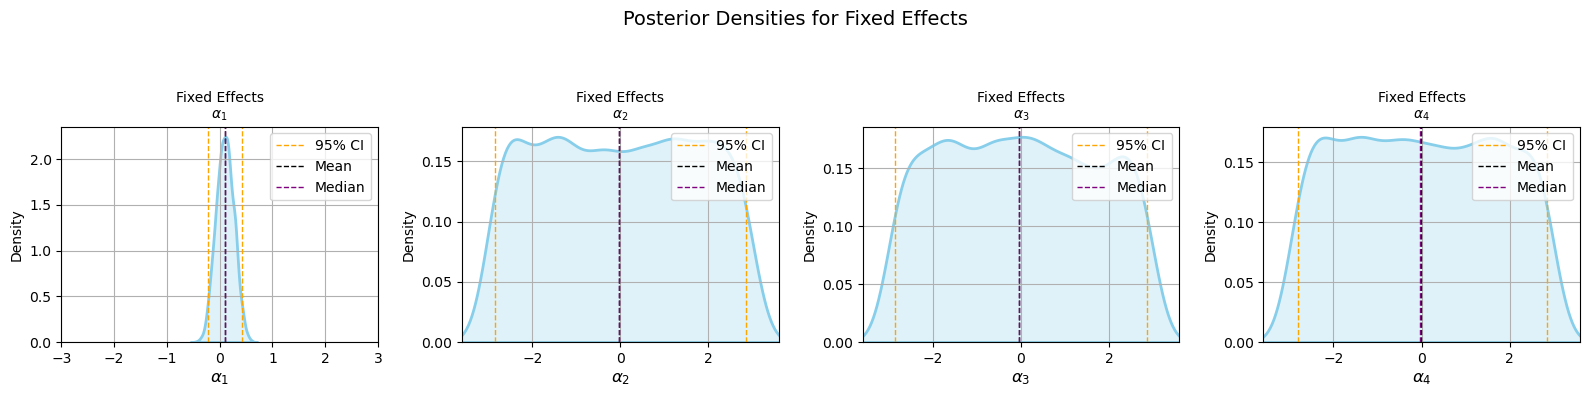


Model: Random Noise
Parameter        Mean     Median    CI 2.5%   CI 97.5%
------------------------------------------------------------
α1             0.0844     0.0913    -0.4607     0.5749
α2            -0.0038     0.0370    -2.7977     2.8479
α3            -0.0400    -0.0141    -2.8300     2.8427
α4             0.0812     0.1239    -2.8683     2.8455
α5             0.4844     0.4110     0.1180     1.2152


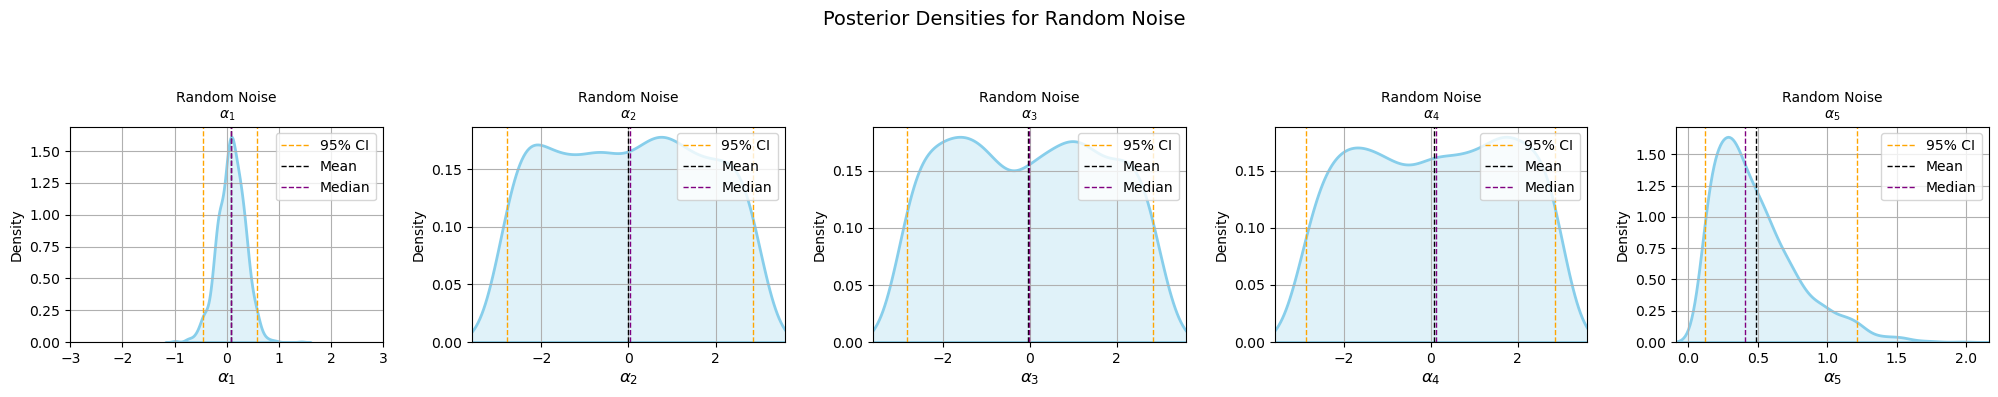


Model: Full Free
Parameter        Mean     Median    CI 2.5%   CI 97.5%
------------------------------------------------------------
α1            -1.0608    -0.9766    -2.6990     0.7157
α2            -0.8099    -0.7250    -2.2823     0.2472
α3            -1.1383    -0.9943    -2.8352    -0.2142
α4             0.0645     0.2290    -1.8013     1.4790
α5            -0.3601    -0.2593    -2.7057     1.7396
α6             0.2361     0.4238    -2.8637     2.8240
α7            -0.7329    -0.8184    -2.3810     0.9165
α8            -1.1878    -1.2047    -2.9189     1.6440
α9             0.1359     0.1290    -2.0867     1.9899
α10           -0.2530    -0.5512    -2.9291     2.8616
α11           -0.0489    -0.0421    -2.9722     2.6059
α12            1.2564     1.1818     0.0676     2.7641
α13            1.5002     1.4507     0.3665     2.6309
α14            0.8314     0.9723    -0.5126     2.1454
α15            0.4100     0.4092    -0.4545     1.0842
α16           -0.1576    -0.5401    -2.87

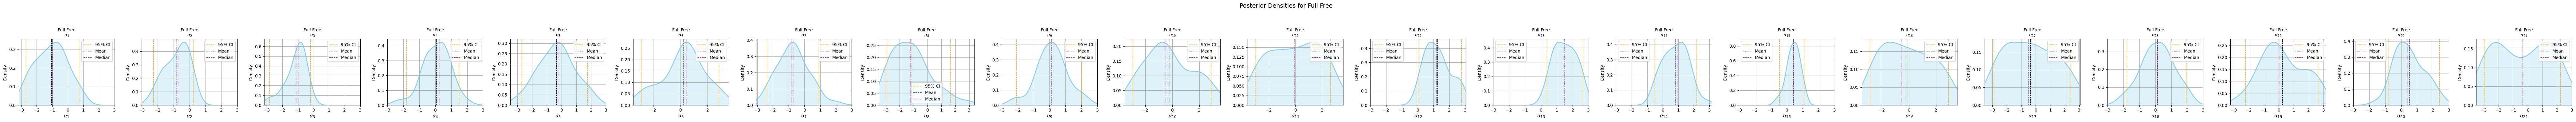


----------------------------------


C:\Users\manan\AppData\Local\Temp\ipykernel_28012\2664845811.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[models[mid]["name"] for mid in model_ids], y=probs, palette='viridis')


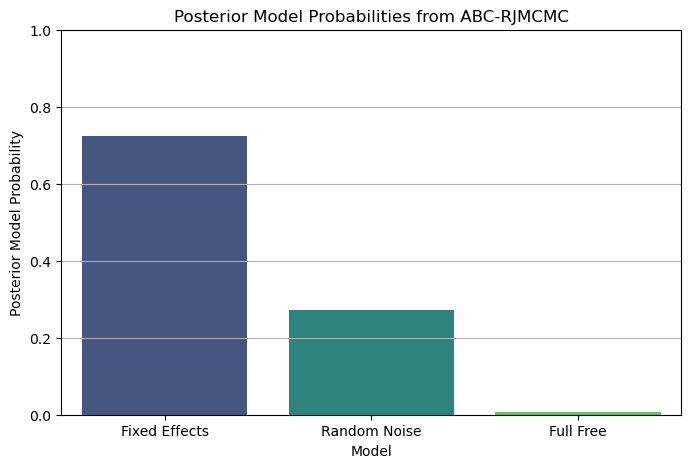

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'crowder_seeds.csv' is in the same directory
file = pd.read_csv("crowder_seeds.csv")
df = pd.DataFrame(file)

np.random.seed(42)

df['E'] = (df['extract'] == 'O75').astype(int)
df['S'] = (df['gen'] == 'bean').astype(int)
df['f'] = 2 * df['E'] + df['S'] + 1

y_obs = df['germ'].values
n_obs = df['n'].values
f = df['f'].values.astype(int)
n_groups = 4
n = len(df)

def model1(params, f):
    params = np.asarray(params)
    return params[f - 1]

def model2(params, f):
    beta = np.asarray(params[:n_groups])
    sigma = np.abs(params[-1])
    return beta[f - 1] + np.random.normal(0, sigma, size=len(f))

def model3(params, f):
    return params

def simulate_binomial_logit(eta, n_trials):
    p = expit(eta)
    n_trials = np.array(n_trials, dtype=np.int32)
    p = np.array(p, dtype=np.float64)
    return np.random.binomial(n_trials, p)

models = {
    1: {"name": "Fixed Effects", "func": model1, "dim": 4, "prior": [(-3, 3)] * 4},
    2: {"name": "Random Noise", "func": model2, "dim": 5, "prior": [(-3, 3)] * 4 + [(0.1, 2)]},
    3: {"name": "Full Free", "func": model3, "dim": n, "prior": [(-3, 3)] * n}
}

def distance(y_sim, y_obs):
    return np.sqrt(mean_squared_error(y_obs, y_sim))

def calibrate_epsilon(y_obs, n_obs, models, f, n_samples=10000):
    epsilons = np.linspace(1, 20, 50)
    acceptance_rates = []
    for eps in epsilons:
        accepted = 0
        for _ in range(n_samples):
            model_id = np.random.choice(list(models.keys()))
            model = models[model_id]
            theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
            eta = model["func"](theta, f)
            y_sim = simulate_binomial_logit(eta, n_obs)
            if distance(y_sim, y_obs) < eps:
                accepted += 1
        acceptance_rates.append(accepted / n_samples)
    best_idx = np.argmin(np.abs(np.array(acceptance_rates) - 0.005))
    best_eps = epsilons[best_idx]
    return best_eps

def calculate_weights(perf, temp=1.0):
    scores = {mid: np.exp(-np.mean(v["rmse"]) / temp) if v["rmse"] else 0 for mid, v in perf.items()}
    total = sum(scores.values())
    return {mid: (s / total if total > 0 else 1/len(perf)) for mid, s in scores.items()}

def abc_rjmcmc_adaptive(y_obs, n_obs, f, models, epsilon, n_iter=50000, bias_start=0.3):
    perf = {k: {"rmse": [], "params": []} for k in models}
    for i in range(n_iter):
        if i < int(bias_start * n_iter):
            model_id = np.random.choice(list(models.keys()))
        else:
            weights = calculate_weights(perf, temp=1.0)
            model_ids = list(weights.keys())
            probs = np.array([weights[mid] for mid in model_ids])
            probs = 0.9 * probs + 0.1 / len(probs)
            probs = probs / probs.sum()
            model_id = np.random.choice(model_ids, p=probs)

        model = models[model_id]
        theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
        eta = model["func"](theta, f)
        y_sim = simulate_binomial_logit(eta, n_obs)
        dist = distance(y_sim, y_obs)
        if dist < epsilon:
            perf[model_id]["rmse"].append(dist)
            perf[model_id]["params"].append(theta)
    return perf

epsilon = calibrate_epsilon(y_obs, n_obs, models, f)
performance = abc_rjmcmc_adaptive(y_obs, n_obs, f, models, epsilon, n_iter=1000000)

model_ids = list(performance.keys())
counts = np.array([len(performance[mid]["params"]) for mid in model_ids])
probs = counts / counts.sum()
model_names = {mid: models[mid]["name"] for mid in models}

print("\nPosterior Model Probabilities (based on accepted samples):")
for mid, p in zip(model_ids, probs):
    print(f"{model_names[mid]}: {p:.3f}")

best_model = model_ids[np.argmax(probs)]
print(f"\nBest Supported Model: {model_names[best_model]}")

weights = calculate_weights(performance)
print("\n[Optional] Sampling Weights (used for adaptive selection):")
for mid in model_ids:
    print(f"{model_names[mid]}: {weights[mid]:.3f}")

def plot_germination_posteriors(performance, models):
    print("\n--- Posterior Parameter Summaries ---")
    for model_id, perf in performance.items():
        params = np.array(perf["params"])
        if params.size == 0:
            print(f"No accepted parameters for model {models[model_id]['name']}. Skipping posterior plot and summary.")
            continue

        model_name = models[model_id]["name"]
        n_params = params.shape[1] if params.ndim > 1 else 1  # Handle 1-D params correctly

        print(f"\nModel: {model_name}")
        print(f"{'Parameter':<10} {'Mean':>10} {'Median':>10} {'CI 2.5%':>10} {'CI 97.5%':>10}")
        print("-" * 60)

        plt.figure(figsize=(4 * n_params, 4))
        for i in range(n_params):
            param_mean = np.mean(params[:, i])
            param_median = np.median(params[:, i])
            ci_lower, ci_upper = np.percentile(params[:, i], [2.5, 97.5])

            print(f"{f'α{i+1}':<10} {param_mean:>10.4f} {param_median:>10.4f} {ci_lower:>10.4f} {ci_upper:>10.4f}")

            plt.subplot(1, n_params, i + 1)
            sns.kdeplot(params[:, i], fill=True, color='skyblue', linewidth=2)
            plt.title(f"{model_name}\n$\\alpha_{{{i+1}}}$", fontsize=10)
            plt.xlabel(r"$\alpha_{{{}}}$".format(i+1), fontsize=12)
            plt.grid(True)

            # Adjust xlim based on posterior and prior
            data_min, data_max = np.min(params[:, i]), np.max(params[:, i])
            prior_low, prior_high = models[model_id]["prior"][i]

            if not np.isnan(data_min) and not np.isnan(data_max):
                plot_min = min(prior_low, data_min - 0.1 * (data_max - data_min))
                plot_max = max(prior_high, data_max + 0.1 * (data_max - data_min))
                plt.xlim(plot_min, plot_max)
            else:
                plt.xlim(prior_low, prior_high)

            # Draw CI bounds
            plt.axvline(ci_lower, color='orange', linestyle='--', linewidth=1, label="95% CI")
            plt.axvline(ci_upper, color='orange', linestyle='--', linewidth=1)
            plt.axvline(param_mean, color='black', linestyle='--', linewidth=1, label="Mean")
            plt.axvline(param_median, color='purple', linestyle='--', linewidth=1, label="Median")
            plt.legend()

        plt.suptitle(f"Posterior Densities for {model_name}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust space for suptitle
        plt.show()
    print("\n----------------------------------")



def plot_model_posteriors(performance, models):
    model_ids = list(performance.keys())
    counts = np.array([len(performance[mid]["params"]) for mid in model_ids])
    probs = counts / counts.sum()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=[models[mid]["name"] for mid in model_ids], y=probs, palette='viridis')
    plt.ylabel("Posterior Model Probability")
    plt.xlabel("Model")
    plt.title("Posterior Model Probabilities from ABC-RJMCMC")
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.show()

# Run the plotting functions
plot_germination_posteriors(performance, models)
plot_model_posteriors(performance, models)